# Taller de Futbol Analytics

La idea de este taller es bla bla ... queremos que se lleven bla bla...

In [153]:
# Primero importamos unas librerías de Python que vamos a usar a lo largo del notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import ipywidgets as widgets
import plotly.express as px

from IPython.display import display
from scipy.stats import zscore
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from adjustText import adjust_text

In [154]:
# Instalamos las librerías necesarias si no las tenemos instaladas

# !pip install adjustText
# !pip install plotly
# !pip install ipywidgets
# !pip install anywidgets

In [155]:
# Obtenemos los datos desde el archivo df_reducido.csv
df = pd.read_csv("datasets_procesados/df_reducido.csv")
df_completo = pd.read_csv("datasets_procesados/df.csv")

In [156]:
# Podemos obtener una primera visualización de los datos viendo sus primeras 5 filas con el comando head()
display(df.head(), df_completo.head())

,Jugador,Equipo,Competición,Posición,Edad,Partidos,Minutos,Goles,Asistencias,xG,...,Bloqueos,TarjetasAmarillas,TarjetasRojas,Goles_Asistencias,xG_xAG,Equiv_90min,EntradasGanadas,AsistDesdeCruzados,Tiros,TirosAlArco
0,Vinicius Junior,Real Madrid,La Liga,FW,24,24,1849,11,5,9.6,...,5,7,1,16,0.74,20.5,8,4,68,21
1,Erling Haaland,Manchester City,Premier League,FW,24,28,2480,21,3,20.8,...,11,2,0,24,0.86,27.6,5,1,99,54
2,Lamine Yamal,Barcelona,La Liga,FW,17,27,2236,6,11,7.4,...,12,3,0,17,0.75,24.8,24,12,101,29
3,Jude Bellingham,Real Madrid,La Liga,MF,21,24,1983,8,7,8.9,...,28,3,1,15,0.56,22.0,28,0,44,16
4,Kylian Mbappe,Real Madrid,La Liga,FW,26,28,2420,22,3,20.0,...,3,3,0,25,0.98,26.9,5,2,121,62


,Player,stats_Nation,stats_Pos,stats_Squad,stats_Comp,stats_Age,stats_Born,stats_MP,stats_Starts,stats_Min,...,misc_OG,misc_Recov,misc_Won,misc_Lost,misc_Won%,first_name,last_name,full_name,market_value_in_eur,highest_market_value_in_eur
0,Vinicius Junior,br BRA,FW,Real Madrid,La Liga,24,2000,24,20,"1,849",...,0,52,1,7,12.5,NaN,Vinicius Junior,Vinicius Junior,200000000.0,200000000.0
1,Erling Haaland,no NOR,FW,Manchester City,Premier League,24,2000,28,28,"2,480",...,0,29,49,45,52.1,Erling,Haaland,Erling Haaland,200000000.0,200000000.0
2,Lamine Yamal,es ESP,FW,Barcelona,La Liga,17,2007,27,25,"2,236",...,0,96,1,1,50.0,NaN,Lamine Yamal,Lamine Yamal,180000000.0,180000000.0
3,Jude Bellingham,eng ENG,MF,Real Madrid,La Liga,21,2003,24,24,"1,983",...,0,72,20,21,48.8,Jude,Bellingham,Jude Bellingham,180000000.0,180000000.0
4,Kylian Mbappe,fr FRA,FW,Real Madrid,La Liga,26,1998,28,28,"2,420",...,0,34,3,5,37.5,Kylian,Mbappe,Kylian Mbappe,170000000.0,200000000.0


Fijense que en los datos que tenemos que tienen solo numeros, hay menos columnas (porque nos quedamos solo con las que tienen números)

In [157]:
# Con este comando podemos ver las columnas e información de los datos que tenemos
display(df.columns, df_completo.columns)

Index(['Jugador', 'Equipo', 'Competición', 'Posición', 'Edad', 'Partidos',
       'Minutos', 'Goles', 'Asistencias', 'xG', 'xAG', 'npxG', 'ValorMercado',
       'PasesCompletados', 'IntentosPase', 'PctPasesCompletados',
       'DistanciaTotalPases', 'DistanciaProgresiva', 'PasesClave', 'Entradas',
       'Intercepciones', 'Bloqueos', 'TarjetasAmarillas', 'TarjetasRojas',
       'Goles_Asistencias', 'xG_xAG', 'Equiv_90min', 'EntradasGanadas',
       'AsistDesdeCruzados', 'Tiros', 'TirosAlArco'],
      dtype='object')

Index(['Player', 'stats_Nation', 'stats_Pos', 'stats_Squad', 'stats_Comp',
       'stats_Age', 'stats_Born', 'stats_MP', 'stats_Starts', 'stats_Min',
       ...
       'misc_OG', 'misc_Recov', 'misc_Won', 'misc_Lost', 'misc_Won%',
       'first_name', 'last_name', 'full_name', 'market_value_in_eur',
       'highest_market_value_in_eur'],
      dtype='object', length=243)

# Gráficos y visualización de datos

In [158]:
# Elegimos el dataframe con el que vamos a trabajar
df_grafico1 = df.copy()

# Filtrar jugadores con más de 90 minutos
df_grafico1 = df_grafico1[df_grafico1["Minutos"] > 90]

# Identificar columnas numéricas
numeric_columns = df_grafico1.select_dtypes(include=[np.number]).columns

# Crear widgets para seleccionar las columnas
x_dropdown = widgets.Dropdown(
    options=numeric_columns,
    value='Goles',
    description='Eje X:'
)

y_dropdown = widgets.Dropdown(
    options=numeric_columns,
    value='Asistencias',
    description='Eje Y:'
)

posiciones_dropdown = widgets.Dropdown(
    options=[
        ('Todos', 'all'),
        ('Delanteros', 'FW'),
        ('Mediocampistas', 'MF'),
        ('Defensores', 'DF'),
        ('Arqueros', 'GK')
    ],
    value='all',
    description='Posición:'
)


# Elegimos que columnas queremos que se normalicen sobre 90 minutos
normalizables = [
    'Goles', 'Asistencias', 'xG', 'xAG', 'npxG', 'Goles_Asistencias', 'xG_xAG',
    'Tiros', 'TirosAlArco', 'PasesClave', 'Entradas', 'Intercepciones', 'Bloqueos',
    'EntradasGanadas', 'AsistDesdeCruzados'
]

# Función para actualizar el gráfico
def update_graph(x_col, y_col, pos):

    df_filtrado = df_grafico1.copy()

    plt.figure(figsize=(10, 6))

    # Filtrar por posición si corresponde
    if pos != 'all':
        df_filtrado = df_filtrado[df_filtrado["Posición"] == pos]

    # Aplico normalización solo si corresponde
    x_data = df_filtrado[x_col]
    y_data = df_filtrado[y_col]

    if x_col in normalizables:
        x_data = 90 * x_data / df_filtrado['Minutos']
    if y_col in normalizables:
        y_data = 90 * y_data / df_filtrado['Minutos']

    # Scatter plot
    plt.scatter(
        x=x_data,
        y=y_data,
        c=np.log10(df_filtrado['ValorMercado'] + 1),  # Sumar 1 para evitar log(0)
        cmap='viridis',
        alpha=0.6,
        s=50
    )
    cbar = plt.colorbar()
    cbar.set_label('Log10(Valor de mercado €)', fontsize=10)

    # Etiquetas dinámicas
    x_label = f"{x_col} {'(cada 90 min)' if x_col in normalizables else ''}"
    y_label = f"{y_col} {'(cada 90 min)' if y_col in normalizables else ''}"

    # Títulos y etiquetas
    plt.title(f'{x_col} vs {y_col} - {pos if pos != "all" else "Todos"}', fontsize=14)
    plt.xlabel(x_label, fontsize=12)
    plt.ylabel(y_label, fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# Conectar los widgets a la función
ui = widgets.VBox([posiciones_dropdown, x_dropdown, y_dropdown])
out = widgets.interactive_output(update_graph, {
    'x_col': x_dropdown,
    'y_col': y_dropdown,
    'pos': posiciones_dropdown
})

# Mostrar los widgets y el gráfico
display(ui, out)

Output()

In [159]:
# Elegimos el dataframe con el que vamos a trabajar
df_grafico1 = df.copy()

# Filtrar jugadores con más de 90 minutos
df_grafico1 = df_grafico1[df_grafico1["Minutos"] > 90]

# Identificar columnas numéricas
numeric_columns = df_grafico1.select_dtypes(include=[np.number]).columns

# Crear widgets
x_dropdown = widgets.Dropdown(
    options=numeric_columns,
    value='Goles',
    description='Eje X:'
)

y_dropdown = widgets.Dropdown(
    options=numeric_columns,
    value='Asistencias',
    description='Eje Y:'
)

posiciones_dropdown = widgets.Dropdown(
    options=[
        ('Todos', 'all'),
        ('Delanteros', 'FW'),
        ('Mediocampistas', 'MF'),
        ('Defensores', 'DF'),
        ('Arqueros', 'GK')
    ],
    value='all',
    description='Posición:'
)

# Columnas que se normalizan a 90 min
normalizables = [
    'Goles', 'Asistencias', 'xG', 'xAG', 'npxG', 'Goles_Asistencias', 'xG_xAG',
    'Tiros', 'TirosAlArco', 'PasesClave', 'Entradas', 'Intercepciones', 'Bloqueos',
    'EntradasGanadas', 'AsistDesdeCruzados'
]

# Función para actualizar el gráfico
def update_graph(x_col, y_col, pos):
    df_filtrado = df_grafico1.copy()

    if pos != 'all':
        df_filtrado = df_filtrado[df_filtrado["Posición"] == pos]

    # Aplico normalización
    x_data = df_filtrado[x_col]
    y_data = df_filtrado[y_col]

    if x_col in normalizables:
        x_data = 90 * x_data / df_filtrado['Minutos']
    if y_col in normalizables:
        y_data = 90 * y_data / df_filtrado['Minutos']

    # Crear etiquetas de ejes
    x_label = f"{x_col} {'(por 90 min)' if x_col in normalizables else ''}"
    y_label = f"{y_col} {'(por 90 min)' if y_col in normalizables else ''}"

    # Crear DataFrame para graficar
    df_plot = pd.DataFrame({
        x_col: x_data,
        y_col: y_data,
        'Jugador': df_filtrado['Jugador'],
        'Posición': df_filtrado['Posición'],
        'Equipo': df_filtrado.get('Equipo', 'N/A'),  # por si no existe la columna
        'Minutos': df_filtrado['Minutos'],
        'ValorMercado': df_filtrado['ValorMercado']
    })

    # Gráfico con plotly
    fig = px.scatter(
        df_plot,
        x=x_col,
        y=y_col,
        color=np.log10(df_plot['ValorMercado'] + 1),
        hover_name='Jugador',
        hover_data={
            x_col: True,
            y_col: True,
            'Posición': True,
            'Equipo': True,
            'Minutos': True,
            'ValorMercado': True
        },
        color_continuous_scale='viridis',
        labels={
            x_col: x_label,
            y_col: y_label,
            'color': 'Log10<br>(Valor Mercado €)'
        },
        title=f"{x_col} vs {y_col} - {pos if pos != 'all' else 'Todos'}"
    )

    fig.update_layout(height=600, width=990)
    fig.show()

# Conectar los widgets
ui = widgets.VBox([posiciones_dropdown, x_dropdown, y_dropdown])
out = widgets.interactive_output(update_graph, {
    'x_col': x_dropdown,
    'y_col': y_dropdown,
    'pos': posiciones_dropdown
})

display(ui, out)


Output()

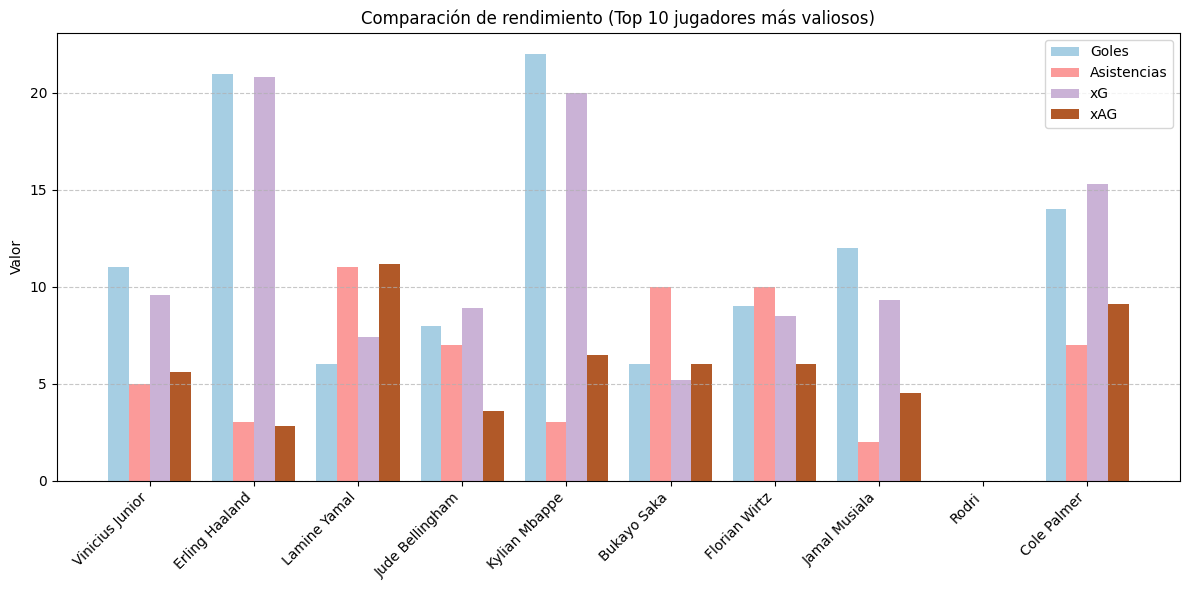

In [160]:
# Elegimos estadísticas y jugadores
estadisticas = ['Goles', 'Asistencias', 'xG', 'xAG']
jugadores_top10 = df.iloc[0:10]
x = np.arange(len(jugadores_top10))
bar_width = 0.2

# Elegimos una paleta de colores
colors = plt.get_cmap("Paired")(np.linspace(0, 1, len(estadisticas)))

# Preparamos el gráfico
fig, ax = plt.subplots(figsize=(12, 6))

# Dibujamos las barras
for i, (stat, color) in enumerate(zip(estadisticas, colors)):
    ax.bar(
        x + i * bar_width,
        jugadores_top10[stat],
        width=bar_width,
        label=stat,
        color=color
    )

# Etiquetas y estilo
ax.set_xticks(x + bar_width * (len(estadisticas)-1) / 2)
ax.set_xticklabels(jugadores_top10["Jugador"], rotation=45, ha='right')
ax.set_ylabel("Valor")
ax.set_title("Comparación de rendimiento (Top 10 jugadores más valiosos)")
ax.legend()
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Mostramos el gráfico
plt.tight_layout()
plt.show()

In [161]:
# Seleccionamos el dataframe con el que vamos a trabajar
df_grafico2 = df.copy()

# Lo ordenamos alfabéticamente por el nombre del jugador
df_grafico2.sort_values("Jugador", inplace=True)

# Seleccionamos los datos que vamos a graficar
stats = [
    "Goles", "Asistencias", "Tiros", "TirosAlArco", "xG", "xAG",
    "PasesCompletados", "PasesClave", "DistanciaProgresiva", "Entradas", "Intercepciones"
]

# Armamos el dataframe con las columnas que nos interesan
df_grafico2 = df_grafico2[["Jugador"] + stats]

# Normalizamos los datos para que estén entre 0 y 1
scaler = MinMaxScaler()
df_grafico2[stats] = scaler.fit_transform(df_grafico2[stats])

# Función que extrae lista de valores normalizados
def valores(j):
    return df_grafico2.loc[df_grafico2["Jugador"] == j, stats].iloc[0].tolist()

# Obtenemos el listado de jugadores y dos jugadores iniciales para comparar
jugadores = df_grafico2["Jugador"]
j1, j2 = "Lionel Messi", "Harry Kane"

# Creamos el FigureWidget con las estadisticas del jugador 1
figw = go.FigureWidget(
    go.Scatterpolar(r=valores(j1), theta=stats, fill="toself", name=j1),
    layout=go.Layout(
        title=f"Comparación: {j1} vs {j2}",
        polar=dict(radialaxis=dict(visible=True, range=[0,1]))
    )
)

# Añadimos el segundo jugador al gráfico
figw.add_trace(go.Scatterpolar(r=valores(j2), theta=stats, fill="toself", name=j2))

# Creamos el menú desplegable para ambos jugadores
dd1 = widgets.Dropdown(options=jugadores, value=j1, description="Jugador 1")
dd2 = widgets.Dropdown(options=jugadores, value=j2, description="Jugador 2")

# Funcion que actualiza el gráfico al cambiar los jugadores
def actualizar(change):
    # trace 0
    figw.data[0].r = valores(dd1.value)
    figw.data[0].name = dd1.value
    # trace 1
    figw.data[1].r = valores(dd2.value)
    figw.data[1].name = dd2.value
    # título
    figw.layout.title.text = f"Comparación: {dd1.value} vs {dd2.value}"

# Actualizamos el gráfico al cambiar los jugadores
dd1.observe(actualizar, names="value")
dd2.observe(actualizar, names="value")

# Mostramos el gráfico interactivo
display(widgets.HBox([dd1, dd2]))
display(figw)

FigureWidget({
    'data': [{'fill': 'toself',
              'name': 'Lionel Messi',
              'r': [0.7407407407407407, 0.6470588235294118, 0.6859504132231405,
                    0.6290322580645161, 0.4916666666666667, 0.35714285714285715,
                    0.2507440476190476, 0.37037037037037035, 0.20051651885781113,
                    0.15463917525773196, 0.03278688524590164],
              'theta': [Goles, Asistencias, Tiros, TirosAlArco, xG, xAG,
                        PasesCompletados, PasesClave, DistanciaProgresiva,
                        Entradas, Intercepciones],
              'type': 'scatterpolar',
              'uid': '5cb08692-be91-46a3-a1e6-aed6bd3a6f08'},
             {'fill': 'toself',
              'name': 'Harry Kane',
              'r': [0.8518518518518519, 0.47058823529411764, 0.7107438016528926,
                    0.5806451612903225, 0.7458333333333332, 0.3839285714285714,
                    0.15848214285714285, 0.35802469135802467, 0.08961114901081765

# Jugadores parecidos

In [162]:
# Nos quedamos con las columnas numéricas del dataframe completo
df_num = df_completo.select_dtypes(include=[np.number])
df_num[df_num.columns] = MinMaxScaler().fit_transform(df_num)

In [163]:
# Definimos una función que nos devuelva, mediante knn, los k jugadores más parecidos para un jugador determinado

def jugadores_parecidos(nombre_jugador, cant_recomendaciones):
    # Obtenemos el índice del jugador
    ind_jugador = df[df["Jugador"]==nombre_jugador].index[0]

    # Inicializamos un NearestNeighbors que busque los n+1 jugadores más parecidos al buscado (porque incluye al jugador buscado)
    neighbors = NearestNeighbors(n_neighbors = cant_recomendaciones + 1).fit(df_num)

    # Obtenemos las distancias a esos jugadores y sus índices
    distances, indices = neighbors.kneighbors(df_num.iloc[[ind_jugador]])

    # Devolvemos el dataset evaluado en esos índices
    res = df.iloc[indices.flatten()]

    # Eliminamos de la lista al mismo jugador
    res = res.drop(ind_jugador, axis=0)
    
    return res

In [164]:
# Obtenemos los 10 jugadores más parecidos a Lionel Messi
jugadores_parecidos("Mohamed Salah", 10)

,Jugador,Equipo,Competición,Posición,Edad,Partidos,Minutos,Goles,Asistencias,xG,...,Bloqueos,TarjetasAmarillas,TarjetasRojas,Goles_Asistencias,xG_xAG,Equiv_90min,EntradasGanadas,AsistDesdeCruzados,Tiros,TirosAlArco
4,Kylian Mbappe,Real Madrid,La Liga,FW,26,28,2420,22,3,20.0,...,3,3,0,25,0.98,26.9,5,2,121,62
20,Harry Kane,Bayern Munich,Bundesliga,FW,31,26,2023,23,8,17.9,...,12,4,0,31,0.98,22.5,9,2,86,36
99,Bryan Mbeumo,Brentford,Premier League,FW,25,30,2694,16,5,9.8,...,21,2,0,21,0.55,29.9,20,14,60,27
182,Mason Greenwood,Marseille,Ligue 1,FW,23,27,2191,15,3,12.2,...,4,1,0,18,0.67,24.3,16,11,88,36
9,Cole Palmer,Chelsea,Premier League,MF,22,29,2530,14,7,15.3,...,14,5,0,21,0.87,28.1,15,14,100,38
6,Florian Wirtz,Leverkusen,Bundesliga,MF,21,25,1876,9,10,8.5,...,23,1,0,19,0.69,20.8,18,6,62,28
48,Bradley Barcola,Paris S-G,Ligue 1,FW,22,28,1832,13,9,12.2,...,22,2,0,22,1.05,20.4,14,3,66,32
16,Alexander Isak,Newcastle Utd,Premier League,FW,25,26,2117,20,5,16.1,...,17,1,0,25,0.85,23.5,5,0,70,32
2,Lamine Yamal,Barcelona,La Liga,FW,17,27,2236,6,11,7.4,...,12,3,0,17,0.75,24.8,24,12,101,29
33,Ousmane Dembele,Paris S-G,Ligue 1,FW,27,26,1528,21,5,14.9,...,3,1,0,26,1.29,17.0,5,3,82,43


# Mejores jugadores

In [165]:
# Separamos el dataset en 4, uno por cada posición
df_delanteros = df_completo[df_completo["stats_Pos"] == "FW"]
df_mediocampistas = df_completo[df_completo["stats_Pos"] == "MF"]
df_defensores = df_completo[df_completo["stats_Pos"] == "DF"]
df_arqueros = df_completo[df_completo["stats_Pos"] == "GK"]

In [166]:
def mejores_jugadores(posicion, cantidad, nacionalidad = None):

    # Decidimos con qué dataframe trabajar según la posición
    if posicion == "delanteros":
        df_pos = df_delanteros
        stats = df_num.columns

    elif posicion == "mediocampistas":
        df_pos = df_mediocampistas
        stats = df_num.columns

    elif posicion == "defensores":
        df_pos = df_defensores
        stats = df_num.columns

    elif posicion == "arqueros":
        df_pos = df_arqueros
        stats = df_num.columns
        
    elif posicion == "todos":
        df_pos = df.copy()
        stats = df_num.columns

    if nacionalidad is not None:
        df_pos = df_pos[df_pos["stats_Nation"].str.contains(nacionalidad, na=False)]

    # Aplicamos Z-Score a las columnas
    df_pos_zcores = df_pos[stats].apply(zscore)

    # Calculamos el puntaje total sumando los Z-Scores de cada estadística, ya que todas las columnas son positivas
    df_pos_zcores["score"] = df_pos_zcores[stats].sum(axis=1)

    # Ordenamos el dataframe por el puntaje total
    df_pos_zcores = df_pos_zcores.sort_values(by="score", ascending=False)

    # Ordenamos el dataframe original por el puntaje total
    mejores_jugadores = df_pos_zcores.head(cantidad)

    # Devolvemos el dataframe original con los mejores jugadores
    return df.loc[mejores_jugadores.index]

In [167]:
# 11 ideal según estadísticas
# Formación: 4-3-3

display(
    mejores_jugadores("delanteros", 3),
    mejores_jugadores("mediocampistas", 3),
    mejores_jugadores("defensores", 4),
    mejores_jugadores("arqueros", 1)
)

#Obs: El dataset que conseguimos, no tiene estadísticas específicas de los arqueros (paradas, arcos en 0, penales atajados, etc.)
#      lo cual explica por qué el resultado no es el Dibu Martínez.

,Jugador,Equipo,Competición,Posición,Edad,Partidos,Minutos,Goles,Asistencias,xG,...,Bloqueos,TarjetasAmarillas,TarjetasRojas,Goles_Asistencias,xG_xAG,Equiv_90min,EntradasGanadas,AsistDesdeCruzados,Tiros,TirosAlArco
70,Mohamed Salah,Liverpool,Premier League,FW,32,30,2657,27,17,22.1,...,6,1,0,44,1.13,29.5,11,12,98,45
24,Raphinha,Barcelona,La Liga,FW,28,28,2252,13,8,14.5,...,22,3,0,21,1.00,25.0,20,14,86,33
2,Lamine Yamal,Barcelona,La Liga,FW,17,27,2236,6,11,7.4,...,12,3,0,17,0.75,24.8,24,12,101,29


,Jugador,Equipo,Competición,Posición,Edad,Partidos,Minutos,Goles,Asistencias,xG,...,Bloqueos,TarjetasAmarillas,TarjetasRojas,Goles_Asistencias,xG_xAG,Equiv_90min,EntradasGanadas,AsistDesdeCruzados,Tiros,TirosAlArco
9,Cole Palmer,Chelsea,Premier League,MF,22,29,2530,14,7,15.3,...,14,5,0,21,0.87,28.1,15,14,100,38
80,Bruno Fernandes,Manchester Utd,Premier League,MF,30,29,2465,8,9,8.7,...,28,4,2,17,0.55,27.4,41,9,75,23
6,Florian Wirtz,Leverkusen,Bundesliga,MF,21,25,1876,9,10,8.5,...,23,1,0,19,0.69,20.8,18,6,62,28


,Jugador,Equipo,Competición,Posición,Edad,Partidos,Minutos,Goles,Asistencias,xG,...,Bloqueos,TarjetasAmarillas,TarjetasRojas,Goles_Asistencias,xG_xAG,Equiv_90min,EntradasGanadas,AsistDesdeCruzados,Tiros,TirosAlArco
34,Trent Alexander-Arnold,Liverpool,Premier League,DF,26,28,2145,2,6,1.6,...,25,4,0,8,0.35,23.8,47,20,38,7
52,Achraf Hakimi,Paris S-G,Ligue 1,DF,26,22,1826,4,6,2.7,...,24,4,0,10,0.43,20.3,34,9,29,12
36,Josko Gvardiol,Manchester City,Premier League,DF,23,29,2557,5,0,4.2,...,33,1,0,5,0.22,28.4,32,1,35,11
146,Theo Hernandez,Milan,Serie A,DF,27,28,2254,3,3,2.5,...,22,4,1,6,0.27,25.0,22,11,36,10


,Jugador,Equipo,Competición,Posición,Edad,Partidos,Minutos,Goles,Asistencias,xG,...,Bloqueos,TarjetasAmarillas,TarjetasRojas,Goles_Asistencias,xG_xAG,Equiv_90min,EntradasGanadas,AsistDesdeCruzados,Tiros,TirosAlArco
825,Mark Flekken,Brentford,Premier League,GK,31,29,2555,0,1,0.0,...,1,1,0,1,0.01,28.4,3,0,0,0


In [168]:
# Mejor 11 ideal de jugadores argentinos, según estadísticas
# Formación: 4-3-3

display(
    mejores_jugadores("delanteros", 3, "ARG"),
    mejores_jugadores("mediocampistas", 3, "ARG"),
    mejores_jugadores("defensores", 4, "ARG"),
    mejores_jugadores("arqueros", 1, "ARG")
)

,Jugador,Equipo,Competición,Posición,Edad,Partidos,Minutos,Goles,Asistencias,xG,...,Bloqueos,TarjetasAmarillas,TarjetasRojas,Goles_Asistencias,xG_xAG,Equiv_90min,EntradasGanadas,AsistDesdeCruzados,Tiros,TirosAlArco
196,Lionel Messi,Inter Miami,MLS,FW,36,19,1489,20,11,11.8,...,4,2,0,31,0.96,16.5,6,1,83,39
17,Lautaro Martinez,Inter,Serie A,FW,27,28,2321,11,3,12.0,...,16,0,0,14,0.62,25.8,15,1,92,32
954,Paulo Dybala,Roma,Serie A,FW,31,24,1417,6,3,6.4,...,12,2,0,9,0.72,15.7,7,5,47,15


,Jugador,Equipo,Competición,Posición,Edad,Partidos,Minutos,Goles,Asistencias,xG,...,Bloqueos,TarjetasAmarillas,TarjetasRojas,Goles_Asistencias,xG_xAG,Equiv_90min,EntradasGanadas,AsistDesdeCruzados,Tiros,TirosAlArco
37,Enzo Fernandez,Chelsea,Premier League,MF,24,28,2230,5,5,4.9,...,30,6,0,10,0.40,24.8,28,4,41,15
19,Alexis Mac Allister,Liverpool,Premier League,MF,26,29,2201,3,3,2.3,...,52,6,0,6,0.26,24.5,49,1,30,9
334,Rodrigo De Paul,Atletico Madrid,La Liga,MF,30,27,1619,3,3,1.2,...,22,6,0,6,0.28,18.0,17,11,14,4


,Jugador,Equipo,Competición,Posición,Edad,Partidos,Minutos,Goles,Asistencias,xG,...,Bloqueos,TarjetasAmarillas,TarjetasRojas,Goles_Asistencias,xG_xAG,Equiv_90min,EntradasGanadas,AsistDesdeCruzados,Tiros,TirosAlArco
1554,Nahuel Tenaglia,Alaves,La Liga,DF,29,26,2273,1,1,1.7,...,24,10,0,2,0.11,25.3,45,7,18,4
351,Facundo Medina,Lens,Ligue 1,DF,25,23,2004,0,1,1.3,...,26,10,1,1,0.13,22.3,25,2,23,3
434,Leonardo Balerdi,Marseille,Ligue 1,DF,26,23,1927,0,0,0.6,...,24,8,1,0,0.06,21.4,34,0,11,1
1038,Nicolas Tagliafico,Lyon,Ligue 1,DF,32,19,1541,3,1,2.6,...,22,6,0,4,0.20,17.1,33,2,22,7


,Jugador,Equipo,Competición,Posición,Edad,Partidos,Minutos,Goles,Asistencias,xG,...,Bloqueos,TarjetasAmarillas,TarjetasRojas,Goles_Asistencias,xG_xAG,Equiv_90min,EntradasGanadas,AsistDesdeCruzados,Tiros,TirosAlArco
329,Emiliano Martinez,Aston Villa,Premier League,GK,32,30,2610,0,0,0.0,...,1,4,0,0,0.01,29.0,2,0,0,0
